# Blood Cell Classification Using CNNs and RNNs

The model architecture will consist of convolutional neural networks (CNN) and a recurrent neural network (RNN) used for feature extraction and a Fully-Connected Layer used for classification and predicting the final output. A CNN-based architecture would be sufficient for the image classification problem. However, recent research suggests that implementing a RNN for feature extraction in parallel to the CNN results in a mimicry of biological neural networks which learn through sequential data.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

### Transfer Learning with AlexNet for CNN Branch

From a wide range of pre-trained CNNs available, this project's original goal was to use the VGG-16 CNN to initialize parameters of the model's first CNN layer through transfer learning. In a past research paper that discussed the recognition of blood cell types using CNNs, two different pre-trained CNN layers were used to supply the first CNN layer with initial parameters. There, the VGG-16 CNN resulted in a higher accuracy compared to the Inceptionv3 network. The VGG-16 CNN has been trained on over 1 million images from ImageNet and has proven to be applicable to a range of other image classification projects through transfer learning.

However, due to the depth of the VGG-16 CNN and the lack of computational power available, the team has pivoted to use the AlexNet CNN instead for transfer learning.

In [ ]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 65.6MB/s]


In [ ]:
torch.manual_seed(1)

In [ ]:
#only want the filter weights, not the classifier
convalexnet = alexnet.features

convalexnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Prototype Model (only CNN + ANN) - not Final

In [ ]:
class cnn_test(nn.Module):
    def __init__(self):
        super(cnn_test, self).__init__()
        self.fc = nn.Linear(256*7*7, 8) 

    def forward(self, x):
        cnnpath = x.view(-1, 256*7*7)
        x=self.fc(cnnpath)
        return x

In [ ]:
cnntest = cnn_test()

In [ ]:
use_cuda=False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/APS360 Project Team/Data/Blood_Cell_Dataset_Small_Split.zip', 'r') #Opens the zip file in read mode
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/APS360 Project Team /Data/Blood_Cell_Dataset_Small_Split.zip', 'r') #fiona's path
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
        [ #resize all images to height and width of 280
         transforms.ToTensor()        #transform images to tensors
         ])

classes = ['basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']

train_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/train", transform=transform)
val_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/val", transform=transform)
test_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/test", transform=transform)

print(len(train_data), len(val_data), len(test_data))

1600 200 200


In [ ]:
import torch.utils.data

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, num_workers=0, shuffle=True)

In [ ]:
train_features = []

for i in enumerate(train_loader, 0):
  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  train_features.append([convalexnet(images), labels])

In [ ]:
train_features[0][0].shape

torch.Size([10, 256, 7, 7])

In [ ]:
val_features = []

for i in enumerate(val_loader, 0):
  dataiter = iter(val_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  val_features.append([convalexnet(images), labels])

In [ ]:
test_features = []

for i in enumerate(test_loader, 0):
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  test_features.append([convalexnet(images), labels])

In [ ]:
def get_accuracy_transfer(model, train=True):
    
    if train == True:
      data = train_features
    else:
      data = val_features

    correct = 0
    total = 0
    for feature in data:
        #feature[0] is the features extracted, features[1] is the label
        output = model(feature[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(feature[1].view_as(pred)).sum().item()
        total += feature[0].shape[0]
    return correct / total

In [ ]:
import time
import matplotlib.pyplot as plt


def train_transfer(model, data, batch_size=20, lr=0.01, num_epochs=2):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for feature in train_features:

            feature[0] = torch.from_numpy(feature[0].detach().numpy())
            out = model(feature[0])             # forward pass
            loss = criterion(out, feature[1]) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(feature[1].view_as(pred)).sum().item()
            Mini_batch_total = feature[0].shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_transfer(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            #print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy_transfer(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

Epoch 0 Finished.  Time per Epoch:   1.55 s 
Epoch 1 Finished.  Time per Epoch:   1.16 s 
Epoch 2 Finished.  Time per Epoch:   1.02 s 
Epoch 3 Finished.  Time per Epoch:   0.95 s 
Epoch 4 Finished.  Time per Epoch:   0.90 s 
Epoch 5 Finished.  Time per Epoch:   0.87 s 
Epoch 6 Finished.  Time per Epoch:   0.85 s 
Epoch 7 Finished.  Time per Epoch:   0.84 s 
Epoch 8 Finished.  Time per Epoch:   0.83 s 
Epoch 9 Finished.  Time per Epoch:   0.82 s 
Epoch 10 Finished.  Time per Epoch:   0.81 s 
Epoch 11 Finished.  Time per Epoch:   0.81 s 
Epoch 12 Finished.  Time per Epoch:   0.82 s 
Epoch 13 Finished.  Time per Epoch:   0.83 s 
Epoch 14 Finished.  Time per Epoch:   0.85 s 
Epoch 15 Finished.  Time per Epoch:   0.85 s 
Epoch 16 Finished.  Time per Epoch:   0.85 s 
Epoch 17 Finished.  Time per Epoch:   0.84 s 
Epoch 18 Finished.  Time per Epoch:   0.84 s 
Epoch 19 Finished.  Time per Epoch:   0.84 s 


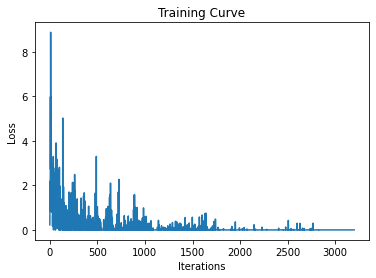

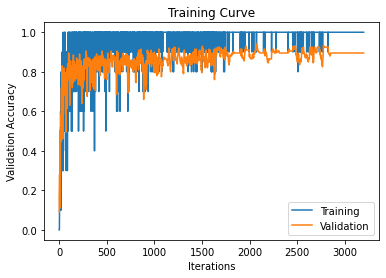

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.895
Total time:   16.71 s  Time per Epoch:   0.84 s 


In [ ]:
train_transfer(cnntest, train_data, 10, 0.01, 20)

In [ ]:
class cnn_test_two(nn.Module):
    def __init__(self):
        super(cnn_test_two, self).__init__()
        self.fc1 = nn.Linear(256*7*7, 64)
        self.fc2 = nn.Linear(64, 8)

    def forward(self, x):
        cnnpath = x.view(-1, 256*7*7)
        x = F.relu(self.fc1(cnnpath))
        x = self.fc2(x)
        return x

Epoch 0 Finished.  Time per Epoch:   2.76 s 
Epoch 1 Finished.  Time per Epoch:   2.87 s 
Epoch 2 Finished.  Time per Epoch:   2.68 s 
Epoch 3 Finished.  Time per Epoch:   2.57 s 
Epoch 4 Finished.  Time per Epoch:   2.56 s 
Epoch 5 Finished.  Time per Epoch:   2.85 s 
Epoch 6 Finished.  Time per Epoch:   3.01 s 
Epoch 7 Finished.  Time per Epoch:   3.10 s 
Epoch 8 Finished.  Time per Epoch:   3.22 s 
Epoch 9 Finished.  Time per Epoch:   3.32 s 
Epoch 10 Finished.  Time per Epoch:   3.36 s 
Epoch 11 Finished.  Time per Epoch:   3.42 s 
Epoch 12 Finished.  Time per Epoch:   3.49 s 
Epoch 13 Finished.  Time per Epoch:   3.51 s 
Epoch 14 Finished.  Time per Epoch:   3.53 s 


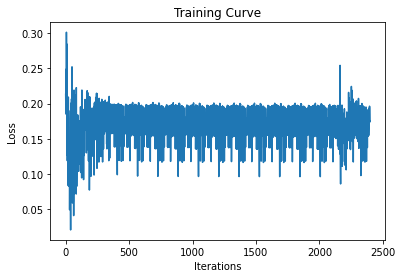

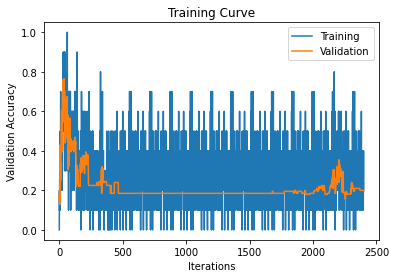

Final Training Accuracy: 0.263125
Final Validation Accuracy: 0.2
Total time:   52.99 s  Time per Epoch:   3.53 s 


In [ ]:
cnntest_two = cnn_test_two()

train_transfer(cnntest_two, train_data, 10, 0.01, 15)

Epoch 0 Finished.  Time per Epoch:   2.38 s 
Epoch 1 Finished.  Time per Epoch:   2.34 s 
Epoch 2 Finished.  Time per Epoch:   2.34 s 
Epoch 3 Finished.  Time per Epoch:   2.33 s 
Epoch 4 Finished.  Time per Epoch:   2.46 s 
Epoch 5 Finished.  Time per Epoch:   2.50 s 
Epoch 6 Finished.  Time per Epoch:   2.47 s 
Epoch 7 Finished.  Time per Epoch:   2.45 s 
Epoch 8 Finished.  Time per Epoch:   2.43 s 
Epoch 9 Finished.  Time per Epoch:   2.46 s 
Epoch 10 Finished.  Time per Epoch:   2.50 s 
Epoch 11 Finished.  Time per Epoch:   2.49 s 
Epoch 12 Finished.  Time per Epoch:   2.47 s 
Epoch 13 Finished.  Time per Epoch:   2.45 s 
Epoch 14 Finished.  Time per Epoch:   2.45 s 
Epoch 15 Finished.  Time per Epoch:   2.49 s 
Epoch 16 Finished.  Time per Epoch:   2.48 s 
Epoch 17 Finished.  Time per Epoch:   2.47 s 
Epoch 18 Finished.  Time per Epoch:   2.46 s 
Epoch 19 Finished.  Time per Epoch:   2.45 s 
Epoch 20 Finished.  Time per Epoch:   2.48 s 
Epoch 21 Finished.  Time per Epoch:   2.47 s

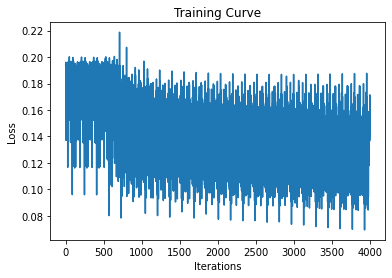

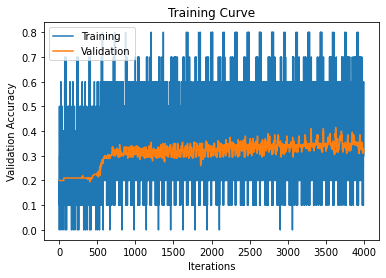

Final Training Accuracy: 0.429375
Final Validation Accuracy: 0.325
Total time:   61.17 s  Time per Epoch:   2.45 s 


In [ ]:
cnntest_three = cnn_test_two()

train_transfer(cnntest_two, train_data, 10, 0.001, 25)

Epoch 0 Finished.  Time per Epoch:   0.60 s 
Epoch 1 Finished.  Time per Epoch:   0.60 s 
Epoch 2 Finished.  Time per Epoch:   0.59 s 
Epoch 3 Finished.  Time per Epoch:   0.59 s 
Epoch 4 Finished.  Time per Epoch:   0.64 s 
Epoch 5 Finished.  Time per Epoch:   0.68 s 
Epoch 6 Finished.  Time per Epoch:   0.70 s 
Epoch 7 Finished.  Time per Epoch:   0.70 s 
Epoch 8 Finished.  Time per Epoch:   0.69 s 
Epoch 9 Finished.  Time per Epoch:   0.68 s 
Epoch 10 Finished.  Time per Epoch:   0.67 s 
Epoch 11 Finished.  Time per Epoch:   0.66 s 
Epoch 12 Finished.  Time per Epoch:   0.66 s 
Epoch 13 Finished.  Time per Epoch:   0.65 s 
Epoch 14 Finished.  Time per Epoch:   0.64 s 


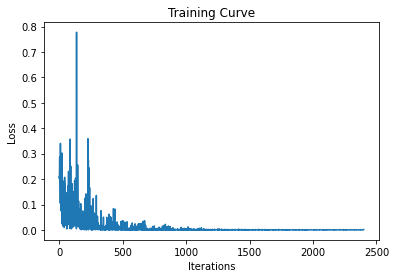

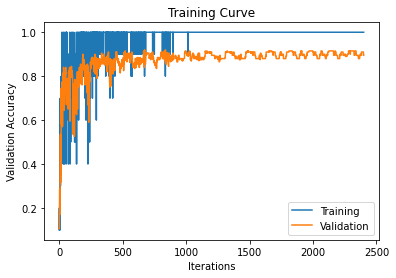

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.895
Total time:    9.66 s  Time per Epoch:   0.64 s 


In [ ]:
cnntest_four = cnn_test()

train_transfer(cnntest_four, train_data, 10, 0.001, 15)

Epoch 0 Finished.  Time per Epoch:   0.61 s 
Epoch 1 Finished.  Time per Epoch:   0.61 s 
Epoch 2 Finished.  Time per Epoch:   0.60 s 
Epoch 3 Finished.  Time per Epoch:   0.60 s 
Epoch 4 Finished.  Time per Epoch:   0.60 s 
Epoch 5 Finished.  Time per Epoch:   0.59 s 
Epoch 6 Finished.  Time per Epoch:   0.59 s 
Epoch 7 Finished.  Time per Epoch:   0.59 s 
Epoch 8 Finished.  Time per Epoch:   0.59 s 
Epoch 9 Finished.  Time per Epoch:   0.61 s 
Epoch 10 Finished.  Time per Epoch:   0.63 s 
Epoch 11 Finished.  Time per Epoch:   0.65 s 
Epoch 12 Finished.  Time per Epoch:   0.66 s 
Epoch 13 Finished.  Time per Epoch:   0.66 s 
Epoch 14 Finished.  Time per Epoch:   0.65 s 


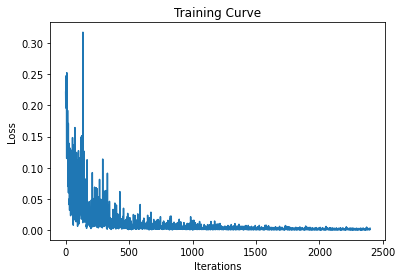

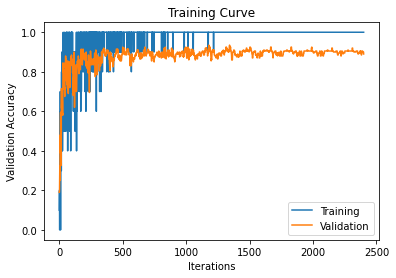

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.89
Total time:    9.77 s  Time per Epoch:   0.65 s 


In [ ]:
cnntest_five = cnn_test()

train_transfer(cnntest_five, train_data, 10, 0.0005, 15)

In [ ]:
# best model test accuracy

def get_accuracy_test(model, data):

    correct = 0
    total = 0
    for feature in data:
        #feature[0] is the features extracted, features[1] is the label
        output = model(feature[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(feature[1].view_as(pred)).sum().item()
        total += feature[0].shape[0]
    return correct / total

#test_acc = get_accuracy_test(cnntest_four, test_features)

#print("Test Accuracy:", test_acc)

In [ ]:
print(test_data.class_to_idx)

print(test_data.imgs)

{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
[('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_145728.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_196745.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_271501.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_338836.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_372309.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_466566.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_478314.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_624477.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_664643.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_705969.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_84086.jpg',

In [ ]:
# do class checking for platelet (smaller than other cells), neutrophil (odd shape), basophil (normal)
from torch.utils.data import DataLoader, Subset

basophil_dset = Subset(test_data, range(0, 25))
neutrophil_dset = Subset(test_data, range(150, 175))
platelet_dset = Subset(test_data, range(175, 200))

basophil_loader = torch.utils.data.DataLoader(basophil_dset, batch_size=10, num_workers=0, shuffle=True)
neutrophil_loader = torch.utils.data.DataLoader(neutrophil_dset, batch_size=10, num_workers=0, shuffle=True)
platelet_loader = torch.utils.data.DataLoader(platelet_dset, batch_size=10, num_workers=0, shuffle=True)

print(len(basophil_dset))
print(len(neutrophil_dset))
print(len(platelet_dset))

"""def get_accuracy_class(model, data):

    correct = 0
    total = 0
    for feature in data:
        #feature[0] is the features extracted, features[1] is the label
        output = model(feature[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(feature[1].view_as(pred)).sum().item()
        total += feature[0].shape[0]
    return correct / total"""

basophil_features = []

for i in enumerate(basophil_loader, 0):
  dataiter = iter(basophil_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  basophil_features.append([convalexnet(images), labels])

neutrophil_features = []

for i in enumerate(neutrophil_loader, 0):
  dataiter = iter(neutrophil_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  neutrophil_features.append([convalexnet(images), labels])

platelet_features = []

for i in enumerate(platelet_loader, 0):
  dataiter = iter(platelet_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  platelet_features.append([convalexnet(images), labels])

b_acc = get_accuracy_class(cnntest_four, basophil_features)
n_acc = get_accuracy_class(cnntest_four, neutrophil_features)
p_acc = get_accuracy_class(cnntest_four, platelet_features)

print("Basophil Test Accuracy:", b_acc)
print("Neutrophil Test Accuracy:", n_acc)
print("Platelet Test Accuracy:", p_acc)

25
25
25
Basophil Test Accuracy: 0.9333333333333333
Neutrophil Test Accuracy: 0.9
Platelet Test Accuracy: 1.0


# Final Model (CNN+RNN)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class proposed2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(proposed2, self).__init__()
        #self.fc = nn.Linear(10*256*7*7 + hidden_size*3, num_class) #temp sizes, idk what the dimensions should be
        #256*7*7 for alexnet, 512*8*8 for vgg16
        self.name = "Proposed2"
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60) #64*34*34 #192*16*16 #192*34*34
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)
    def forward(self, x):
        
        cnnpath = convalexnet(x) #convgg16(x)
        #cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        #if use_cuda:
        h0=h0.to(device)
        
        rnnpath, __=self.rnn(x, h0)

        rnnpath = rnnpath[-1,:,:]
        
        cnnpath = torch.flatten(cnnpath, 1)
        cnnpath = F.relu(self.fcCNN(cnnpath))
        rnnpath = F.relu(self.fcRNN(rnnpath))
        
        merged = torch.cat((cnnpath, rnnpath),1)
        #print(merged.shape)
        x = self.fc(merged)

        return x

In [ ]:
#accuracy function??

def get_accuracy(model, data):
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=16):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          
        #############################################
        #print("here",imgs.shape)
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1] #idk if model will give probability of the classes or what
        #print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item() #do we need to apply soft max??
        total += imgs.shape[0]
    return correct / total

In [ ]:
import matplotlib.pyplot as plt
import time
def train_pro(model, data, name, batch_size, learning_rate, num_epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    start_time=time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        for imgs, labels in iter(train_loader):
            #print("Iter ", epoch)
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              #print("eexcuted")
              #model.cuda()
            #############################################
            model = model.cuda()
            imgs = imgs.cuda()
            out = model(imgs)             # forward pass

            #print(labels)

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, data)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_data))  # compute validation accuracy
            n += 1
        print((f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}"))
        print("Validation Accuracy:", val_acc[-1])

        #save the model
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), model_path)
    
    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("total time:", end_time-start_time)

In [ ]:
prop2 = proposed2(78400, 64,8)
#get_accuracy(prop2,test_loader)

In [ ]:
use_cuda = True
#firstlayers.cuda()
#prop2.cuda()
prop2.to(device)
convalexnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Epoch 0
Epoch 1: Train acc: 0.125
Epoch 1
Epoch 2: Train acc: 0.125
Epoch 2
Epoch 3: Train acc: 0.125
Epoch 3
Epoch 4: Train acc: 0.125
Epoch 4
Epoch 5: Train acc: 0.125
Epoch 5
Epoch 6: Train acc: 0.125
Epoch 6
Epoch 7: Train acc: 0.125
Epoch 7
Epoch 8: Train acc: 0.125
Epoch 8
Epoch 9: Train acc: 0.125
Epoch 9
Epoch 10: Train acc: 0.125
Epoch 10
Epoch 11: Train acc: 0.125
Epoch 11
Epoch 12: Train acc: 0.125
Epoch 12
Epoch 13: Train acc: 0.125
Epoch 13
Epoch 14: Train acc: 0.125
Epoch 14
Epoch 15: Train acc: 0.125


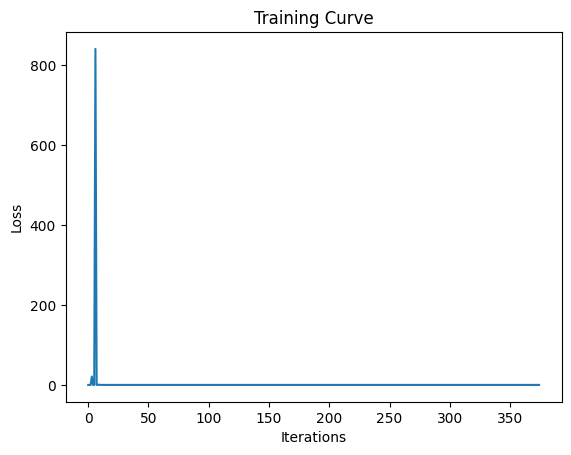

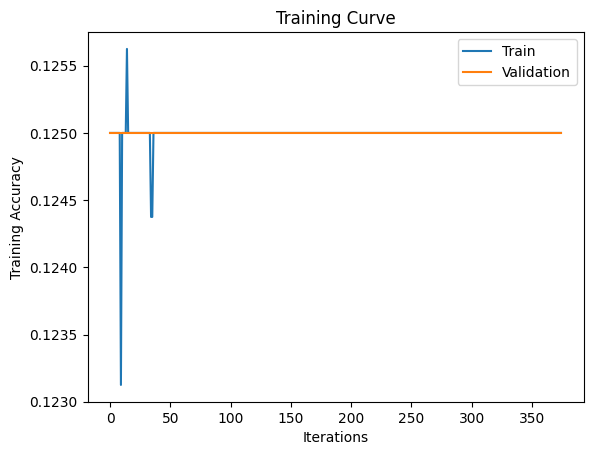

Final Training Accuracy: 0.125
Final Validation Accuracy: 0.125
total time: 2037.4621167182922


In [ ]:
train_pro(prop2, train_data, batch_size=64, learning_rate=0.01, num_epochs=15)

In [ ]:
train_pro(prop2, train_data, batch_size=64, learning_rate=0.01, num_epochs=5)

Epoch 0
Epoch 1: Train acc: 0.125
Epoch 1


KeyboardInterrupt: ignored

Epoch 0
Epoch 1: Train acc: 0.125
Epoch 1
Epoch 2: Train acc: 0.125
Epoch 2
Epoch 3: Train acc: 0.125
Epoch 3
Epoch 4: Train acc: 0.125
Epoch 4
Epoch 5: Train acc: 0.125


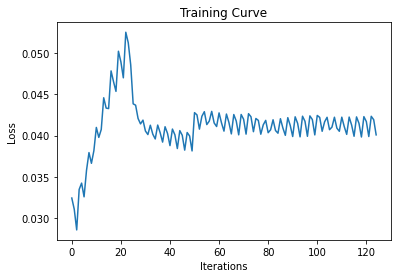

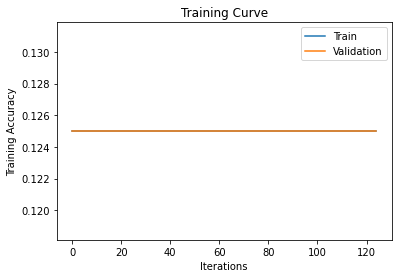

Final Training Accuracy: 0.125
Final Validation Accuracy: 0.125


In [ ]:
train_pro(prop2, train_data, batch_size=64, learning_rate=0.1, num_epochs=5)

Epoch 0
Epoch 1: Train acc: 0.125
Epoch 1
Epoch 2: Train acc: 0.125
Epoch 2
Epoch 3: Train acc: 0.125
Epoch 3
Epoch 4: Train acc: 0.123125
Epoch 4
Epoch 5: Train acc: 0.125
Epoch 5
Epoch 6: Train acc: 0.125
Epoch 6
Epoch 7: Train acc: 0.125
Epoch 7
Epoch 8: Train acc: 0.125
Epoch 8
Epoch 9: Train acc: 0.125
Epoch 9
Epoch 10: Train acc: 0.125
Epoch 10
Epoch 11: Train acc: 0.125
Epoch 11
Epoch 12: Train acc: 0.125
Epoch 12
Epoch 13: Train acc: 0.125
Epoch 13
Epoch 14: Train acc: 0.125
Epoch 14
Epoch 15: Train acc: 0.125
Epoch 15
Epoch 16: Train acc: 0.125
Epoch 16
Epoch 17: Train acc: 0.125
Epoch 17
Epoch 18: Train acc: 0.125
Epoch 18
Epoch 19: Train acc: 0.125625
Epoch 19
Epoch 20: Train acc: 0.125625


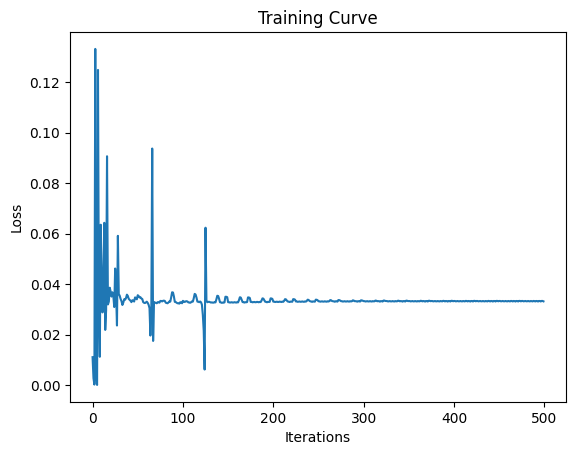

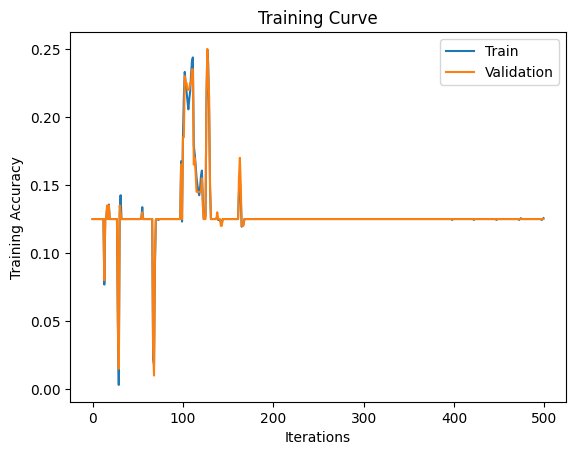

Final Training Accuracy: 0.125625
Final Validation Accuracy: 0.125
total time: 2759.9957752227783


In [ ]:
train_pro(prop2, train_data, batch_size=64, learning_rate=0.01, num_epochs=20)

Epoch 0
tensor([7, 4, 5, 3, 0, 6, 1, 7, 5, 0, 6, 4, 4, 6, 3, 1, 7, 0, 7, 0, 6, 4, 7, 2,
        2, 1, 4, 3, 4, 4, 6, 7, 3, 3, 1, 2, 0, 5, 0, 6, 7, 1, 2, 6, 4, 7, 3, 2,
        6, 7, 5, 1, 3, 0, 5, 2, 6, 5, 4, 4, 3, 0, 6, 2], device='cuda:0')
tensor([5, 2, 1, 6, 2, 2, 1, 1, 5, 3, 7, 7, 5, 0, 5, 1, 4, 1, 5, 1, 7, 2, 7, 5,
        2, 3, 6, 5, 1, 3, 3, 4, 5, 2, 7, 1, 6, 6, 2, 2, 3, 3, 2, 7, 3, 4, 4, 2,
        0, 6, 3, 3, 6, 3, 7, 5, 3, 1, 5, 2, 7, 6, 7, 2], device='cuda:0')
tensor([6, 7, 2, 0, 3, 5, 5, 4, 4, 2, 6, 3, 6, 7, 5, 3, 3, 3, 7, 0, 0, 5, 2, 6,
        1, 6, 1, 1, 7, 4, 1, 5, 7, 3, 0, 2, 5, 4, 1, 1, 5, 4, 2, 3, 3, 2, 6, 5,
        0, 7, 5, 6, 4, 1, 7, 7, 2, 1, 2, 0, 5, 4, 3, 7], device='cuda:0')
tensor([5, 5, 7, 2, 5, 4, 7, 3, 1, 7, 1, 2, 0, 4, 7, 0, 7, 5, 6, 3, 7, 1, 7, 7,
        2, 1, 1, 4, 3, 7, 0, 7, 4, 1, 3, 3, 5, 4, 2, 7, 7, 2, 0, 6, 6, 7, 5, 7,
        7, 2, 2, 0, 2, 6, 6, 3, 5, 5, 4, 0, 3, 6, 3, 0], device='cuda:0')
tensor([4, 7, 1, 1, 5, 3, 6, 7, 3, 1, 3, 2, 2, 6, 1, 2, 

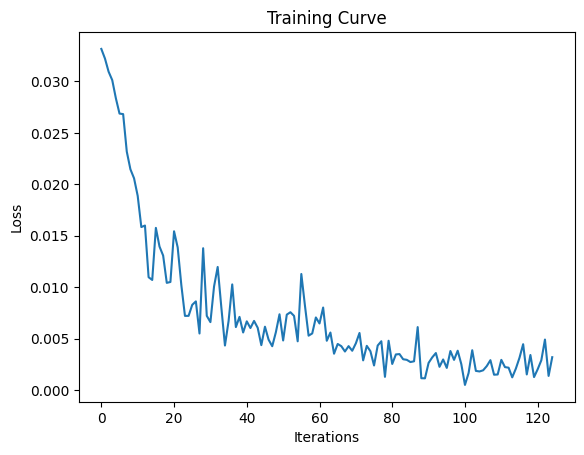

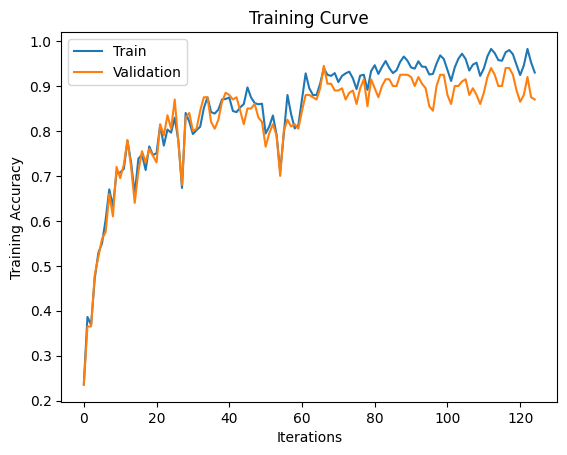

Final Training Accuracy: 0.93
Final Validation Accuracy: 0.87
total time: 663.2049884796143


In [ ]:
prop3 = proposed2(78400, 64,8)

use_cuda = True
device = "cuda"
prop3.to(device)
convalexnet.to(device)
train_pro(prop3, train_data, batch_size=64, learning_rate=0.01, num_epochs=5)

Epoch 0
Epoch 1: Train acc: 0.795625
Validation Accuracy: 0.805
Epoch 1
Epoch 2: Train acc: 0.868125
Validation Accuracy: 0.85
Epoch 2
Epoch 3: Train acc: 0.921875
Validation Accuracy: 0.88
Epoch 3
Epoch 4: Train acc: 0.929375
Validation Accuracy: 0.89
Epoch 4
Epoch 5: Train acc: 0.981875
Validation Accuracy: 0.9
Epoch 5
Epoch 6: Train acc: 0.981875
Validation Accuracy: 0.905
Epoch 6
Epoch 7: Train acc: 0.995625
Validation Accuracy: 0.925
Epoch 7
Epoch 8: Train acc: 0.998125
Validation Accuracy: 0.92
Epoch 8
Epoch 9: Train acc: 1.0
Validation Accuracy: 0.925
Epoch 9
Epoch 10: Train acc: 1.0
Validation Accuracy: 0.94


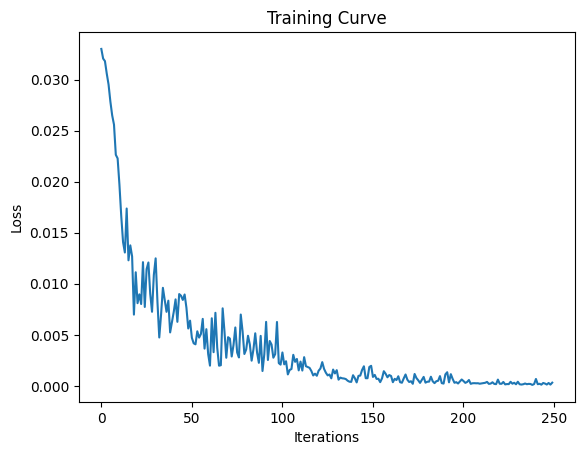

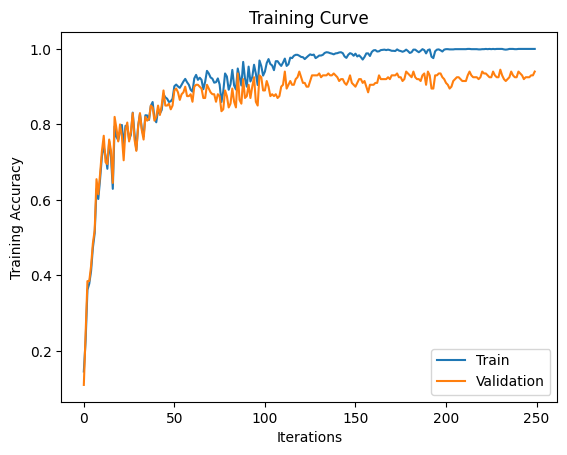

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.94
total time: 1337.1035676002502


In [ ]:
prop4 = proposed2(78400, 32,8)

use_cuda = True
device = "cuda"
prop4.to(device)
convalexnet.to(device)
train_pro(prop4, train_data, "Proposed2", batch_size=64, learning_rate=0.01, num_epochs=10)

Epoch 0
Epoch 1: Train acc: 0.78375
Validation Accuracy: 0.79
Epoch 1
Epoch 2: Train acc: 0.913125
Validation Accuracy: 0.89
Epoch 2
Epoch 3: Train acc: 0.91125
Validation Accuracy: 0.85
Epoch 3
Epoch 4: Train acc: 0.96875
Validation Accuracy: 0.925
Epoch 4
Epoch 5: Train acc: 0.883125
Validation Accuracy: 0.855
Epoch 5
Epoch 6: Train acc: 0.94625
Validation Accuracy: 0.865
Epoch 6
Epoch 7: Train acc: 0.989375
Validation Accuracy: 0.91
Epoch 7
Epoch 8: Train acc: 0.993125
Validation Accuracy: 0.93
Epoch 8
Epoch 9: Train acc: 0.99125
Validation Accuracy: 0.92
Epoch 9
Epoch 10: Train acc: 0.999375
Validation Accuracy: 0.94


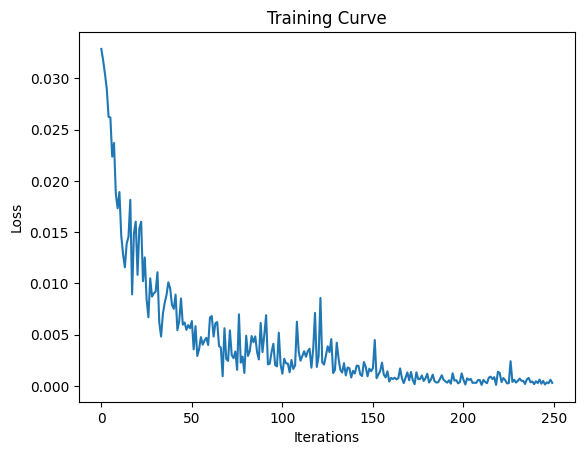

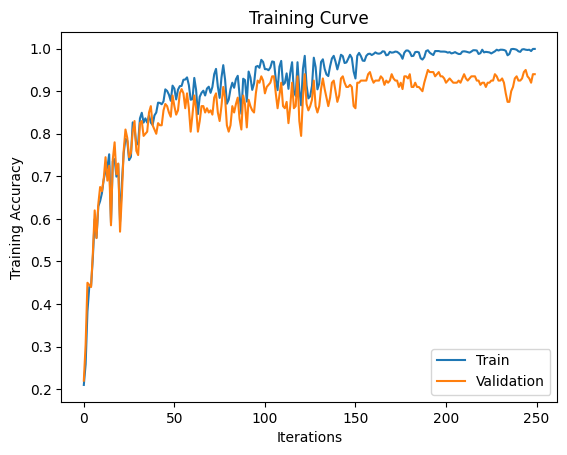

Final Training Accuracy: 0.999375
Final Validation Accuracy: 0.94
total time: 1325.4492807388306


In [ ]:
prop5 = proposed2(78400, 128,8)

use_cuda = True
device = "cuda"
prop5.to(device)
convalexnet.to(device)
train_pro(prop5, train_data, "h128", batch_size=64, learning_rate=0.01, num_epochs=10)

Epoch 0
Epoch 1: Train acc: 0.725
Validation Accuracy: 0.72
Epoch 1
Epoch 2: Train acc: 0.85875
Validation Accuracy: 0.85
Epoch 2
Epoch 3: Train acc: 0.93625
Validation Accuracy: 0.9
Epoch 3
Epoch 4: Train acc: 0.964375
Validation Accuracy: 0.925
Epoch 4
Epoch 5: Train acc: 0.958125
Validation Accuracy: 0.915
Epoch 5
Epoch 6: Train acc: 0.978125
Validation Accuracy: 0.93
Epoch 6
Epoch 7: Train acc: 0.98
Validation Accuracy: 0.925
Epoch 7
Epoch 8: Train acc: 0.98875
Validation Accuracy: 0.94
Epoch 8
Epoch 9: Train acc: 0.99625
Validation Accuracy: 0.92
Epoch 9
Epoch 10: Train acc: 0.996875
Validation Accuracy: 0.92


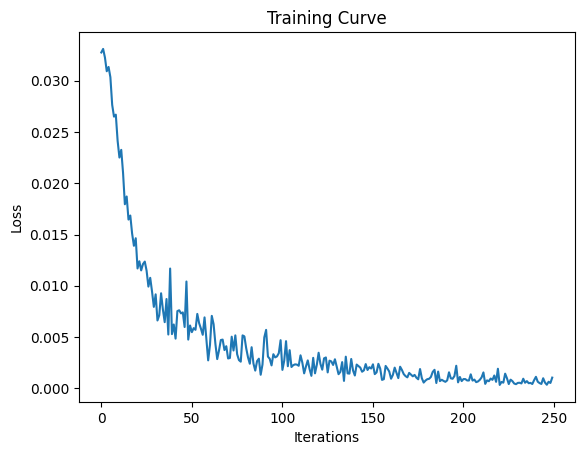

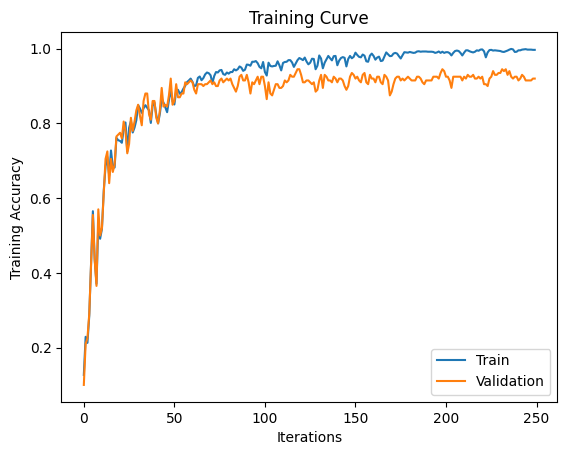

Final Training Accuracy: 0.996875
Final Validation Accuracy: 0.92
total time: 1306.0123972892761


In [ ]:
prop6 = proposed2(78400, 64,8)

use_cuda = True
device = "cuda"
prop6.to(device)
convalexnet.to(device)
train_pro(prop6, train_data, "h64", batch_size=64, learning_rate=0.005, num_epochs=10)

Epoch 0
Epoch 1: Train acc: 0.776875
Validation Accuracy: 0.81
Epoch 1
Epoch 2: Train acc: 0.893125
Validation Accuracy: 0.9
Epoch 2
Epoch 3: Train acc: 0.95125
Validation Accuracy: 0.885
Epoch 3
Epoch 4: Train acc: 0.886875
Validation Accuracy: 0.82
Epoch 4
Epoch 5: Train acc: 0.989375
Validation Accuracy: 0.92
Epoch 5
Epoch 6: Train acc: 0.98375
Validation Accuracy: 0.915
Epoch 6
Epoch 7: Train acc: 0.99
Validation Accuracy: 0.915
Epoch 7
Epoch 8: Train acc: 0.989375
Validation Accuracy: 0.92
Epoch 8
Epoch 9: Train acc: 0.99875
Validation Accuracy: 0.915
Epoch 9
Epoch 10: Train acc: 1.0
Validation Accuracy: 0.935


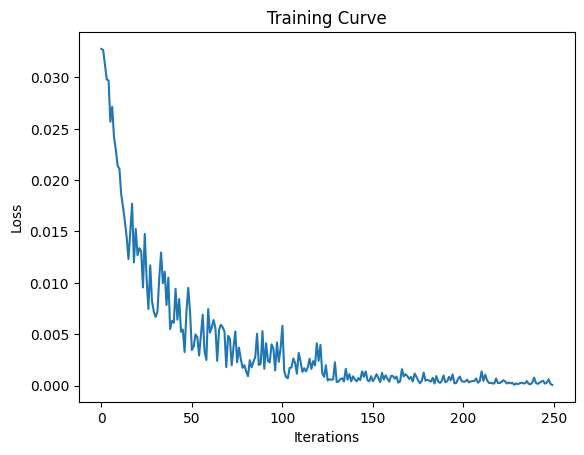

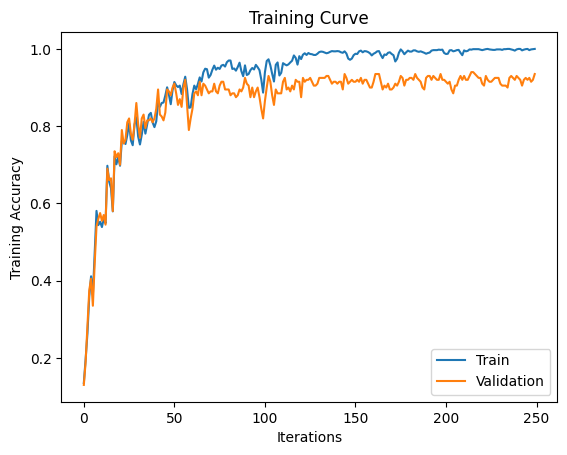

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.935
total time: 1310.2739770412445


In [ ]:
prop7 = proposed2(78400, 64,8)

use_cuda = True
device = "cuda"
prop7.to(device)
convalexnet.to(device)
train_pro(prop7, train_data, "h64_2", batch_size=64, learning_rate=0.01, num_epochs=10)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = "cpu"

In [ ]:
get_accuracy(final, test_data)

0.925

# How to load the model

download one of the models
upload it here
take note of what the path is

In [ ]:
hidden_size = 64 #this needs to be the hidden size of the model you chose
final = proposed2(78400, hidden_size, 8)
model_path = "/content/model_h64_bs64_lr0.005_epoch7" # the path of the model you chose
state = torch.load(model_path)
final.load_state_dict(state)

<All keys matched successfully>

# Extra Work Done - Not Used

In [ ]:
class primary_model(nn.Module):
  def __init__(self, input_size, hidden_size, num_class):
    super(primary_model, self).__init__()
    self
    # write parallel RNN branch
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True) # keep the original plan from proposal and use GRUs?
    self.fc = nn.Linear(hidden_size, num_class)
  def forward(self, x):
    # Set the initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, __ = self.rnn(x, h0)
    # Pass the output of the last step to the classifier
    return self.fc(out[:,-1,:])

In [ ]:
class proposed(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(proposed, self).__init__()
        #self.fc = nn.Linear(10*256*7*7 + hidden_size*3, num_class) #temp sizes, idk what the dimensions should be
        #256*7*7 for alexnet, 512*8*8 for vgg16
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60)
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)
    def forward(self, x):
        #y = torch.flatten(x, 1)
        #print(x.size())
        if use_cuda:
          convalexnet.cuda
        cnnpath = convalexnet(x) #convgg16(x)
        #cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        if use_cuda:
          h0.cuda()
        #print("test",x.size(dim=0), x.dim)
        #print(h0.size, h0.dim)
        rnnpath, __=self.rnn(x, h0)
        #print(rnnpath.shape) #swap dimensions

        rnnpath = rnnpath[-1,:,:]
        #print(cnnpath.shape, rnnpath.shape)

        cnnpath = torch.flatten(cnnpath, 1)
        cnnpath = F.relu(self.fcCNN(cnnpath))
        rnnpath = F.relu(self.fcRNN(rnnpath))
        #print(cnnpath.shape, rnnpath.shape)
        

        merged = torch.cat((cnnpath, rnnpath),1)
        #print(merged.shape)
        x = self.fc(merged)

        return x

In [ ]:
#accuracy function??

"""def get_accuracy(model, train):
    correct = 0
    total = 0

    if train == True:
      data_loader = train_loader
    else:
      data_loader = val_loader

    for imgs, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          
        #############################################
        #print("here",imgs.shape)
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1] #idk if model will give probability of the classes or what
        #print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item() #do we need to apply soft max??
        total += imgs.shape[0]
    return correct / total""""

In [ ]:
proposed1 = proposed(78400, 64,8)

if use_cuda and torch.cuda.is_available():
  proposed1.cuda

NameError: ignored

In [ ]:
get_accuracy(proposed1,test_loader)

0.155

In [ ]:
train_pro(proposed1, train_data, batch_size=64, learning_rate=0.01, num_epochs=2)

NameError: ignored

In [ ]:
import time
import matplotlib.pyplot as plt


def train_transfer_pro(model, data, batch_size=20, lr=0.01, num_epochs=2):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    train_features = []
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

    for i in enumerate(train_loader, 0):
      dataiter = iter(train_loader)
      images, labels = next(dataiter)
      # images = images.cuda()
      # labels = labels.cuda()
      train_features.append([convalexnet(images), labels])

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        i=0
        for imgs,labels in train_loader: #can i guarantee that the features will always sync up with the inputs

            feature[i][0] = torch.from_numpy(feature[i][0].detach().numpy())
            out = model(img, feature[i][0])             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            i+=1

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(feature[1].view_as(pred)).sum().item()
            Mini_batch_total = feature[0].shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_transfer(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            #print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy_transfer(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

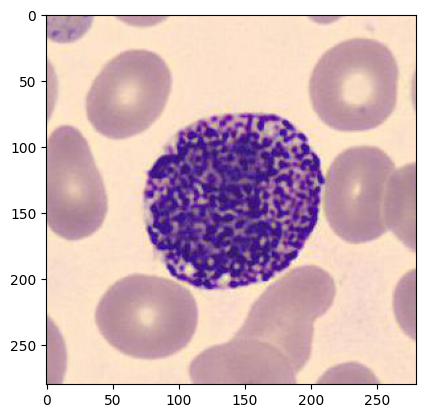

In [ ]:
plat = plt.imread('/tmp/content/Blood_Cell_Dataset_Small_Split/train/basophil/BA_119131.jpg')
plt.imshow(plat)

In [ ]:
a=a.to(device)

In [ ]:
#convert to tensor
a = torch.from_numpy(plat) # turn img into a PyTorch tensor
print(a.shape)
print(a.dtype)
a = a.float()
print(a.dtype)
a = a.permute(2,0,1)      # move the channel dimension to the beginning
print(a.shape)

torch.Size([280, 280, 3])
torch.uint8
torch.float32
torch.Size([3, 280, 280])


In [ ]:
plat_features = firstlayers(a)
plat_features.shape

torch.Size([192, 34, 34])

In [ ]:
b = plat_features.detach().numpy()
b = (b - b.min()) / (b.max() - b.min())
print(b.shape)
print(b[0, 0].shape)

(192, 16, 16)
(16,)


In [ ]:
overfit_dir = os.path.join('/content/drive/My Drive/APS360 Project Team', 'overfit/')
classes = ['basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']
overfit_data = torchvision.datasets.ImageFolder(overfit_dir, transform=transform)

In [ ]:
import numpy as np
def get_accuracy_overfit(model):
    data = overfit_data
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=16):
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_overfit(model, data, batch_size, learning_rate, num_epochs=20):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            fig = plt.figure(figsize=(25,4))
            for idx in np.arange(16):
              ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
              plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
              ax.set_title(classes[labels[idx]])

            #for img in imgs:
              #plt.imshow(np.transpose(img, (1,2,0)))

            out = model(imgs)             # forward pass
            print("out: {}".format(out))
            print("label: {}".format(labels))

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy_overfit(model)) # compute training accuracy 
            n += 1
        print((f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}"))
    

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))

proposed2(
  (rnn): RNN(78400, 64, batch_first=True)
  (fcCNN): Linear(in_features=12544, out_features=60, bias=True)
  (fcRNN): Linear(in_features=64, out_features=60, bias=True)
  (fc): Linear(in_features=120, out_features=8, bias=True)
)
out: tensor([[ 0.1400, -0.2468, -0.0355, -0.0253,  0.2627,  0.0683,  0.2785, -0.4108],
        [ 0.1610, -0.0423,  0.0430,  0.1010,  0.2238,  0.0611,  0.4903, -0.1531],
        [ 0.1690, -0.1543, -0.0071,  0.1003,  0.2455,  0.1127,  0.2686, -0.3175],
        [ 0.0562, -0.2260, -0.0458,  0.0141,  0.3340,  0.0694,  0.3612, -0.2698],
        [ 0.1702, -0.0899, -0.0547,  0.0652,  0.4027,  0.1935,  0.4006, -0.2593],
        [ 0.0267, -0.0048,  0.1229,  0.0820,  0.4093,  0.1257,  0.3886, -0.2341],
        [-0.0954, -0.1803, -0.0021,  0.0173,  0.1950, -0.0525,  0.4055, -0.1818],
        [ 0.0215, -0.2755, -0.0139,  0.0760,  0.3317,  0.0388,  0.3286, -0.1921],
        [-0.0454, -0.1494,  0.0615,  0.0604,  0.1556, -0.0455,  0.0870, -0.2867],
        [ 0.0892

KeyboardInterrupt: ignored

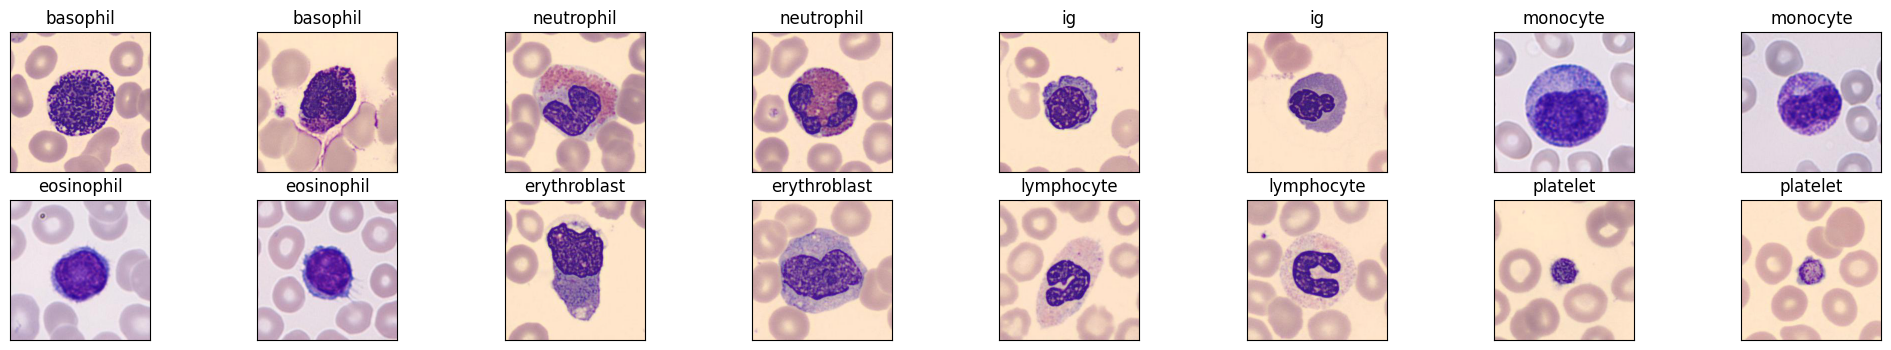

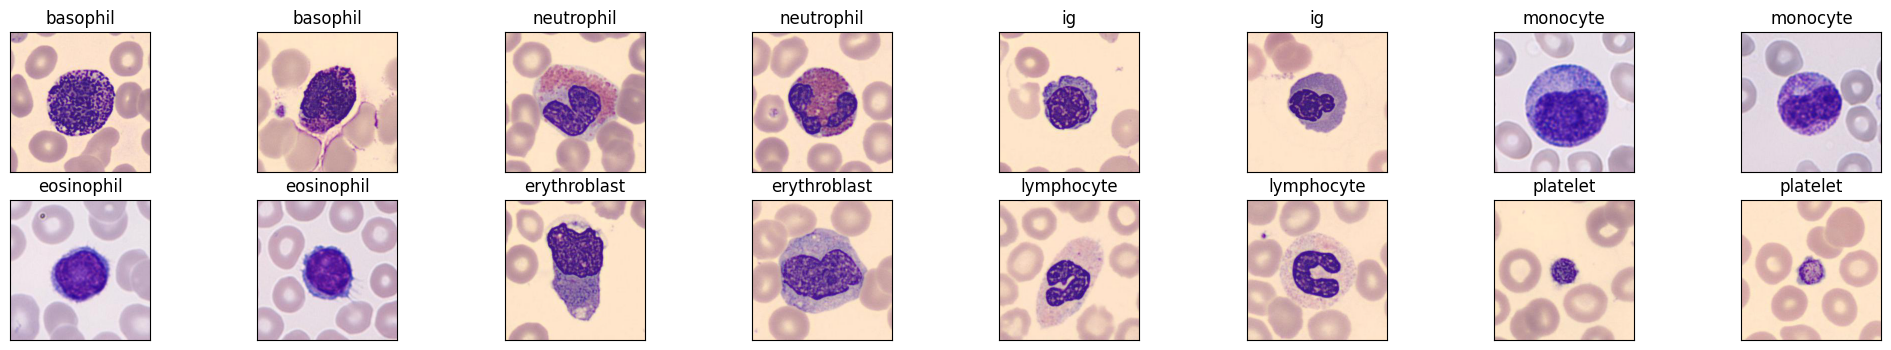

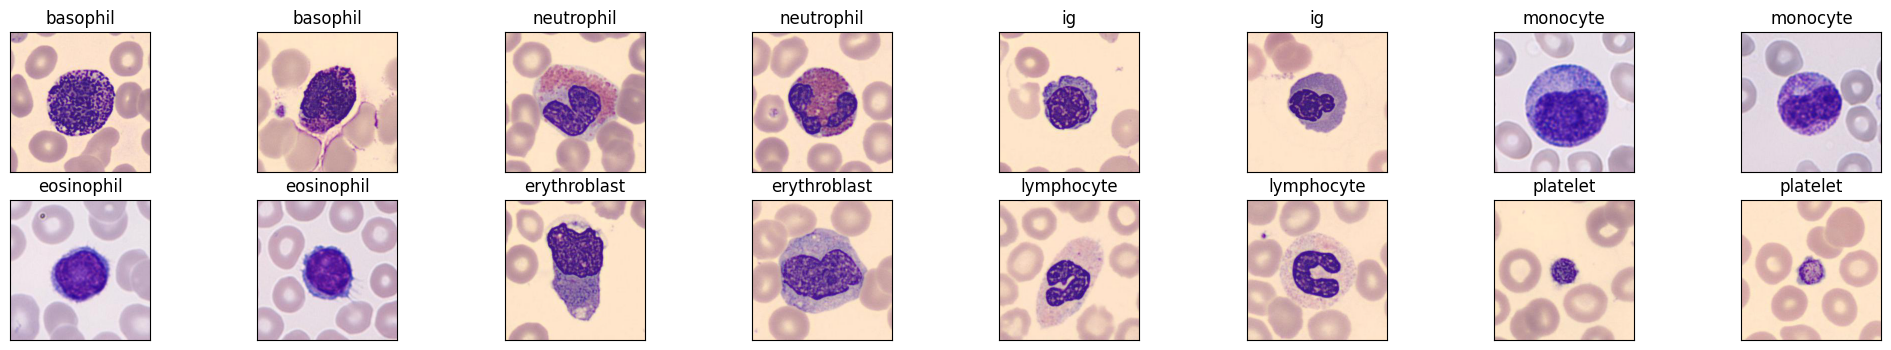

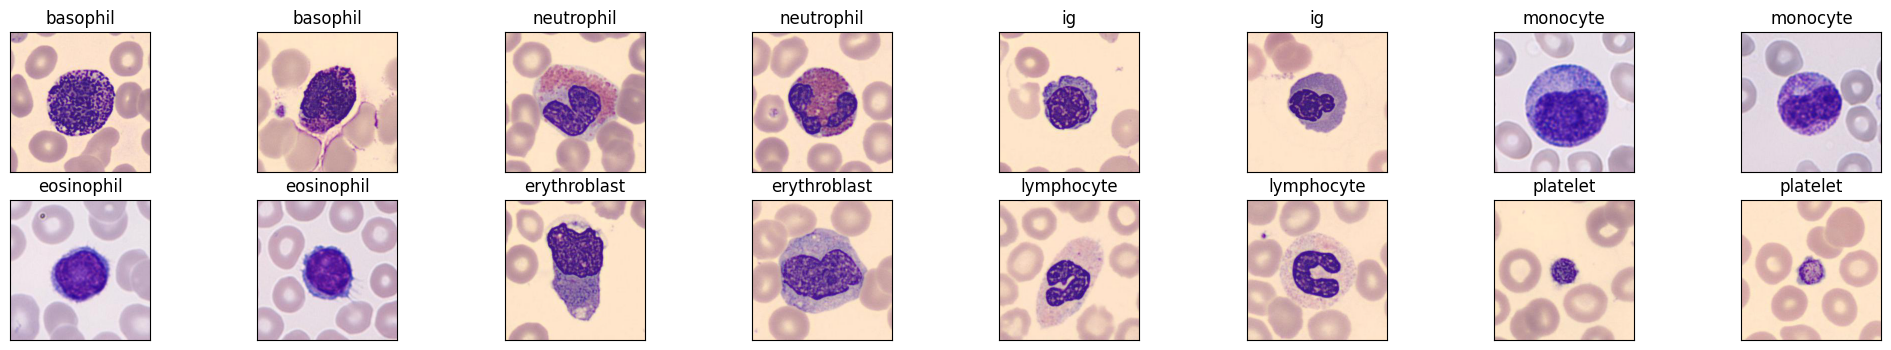

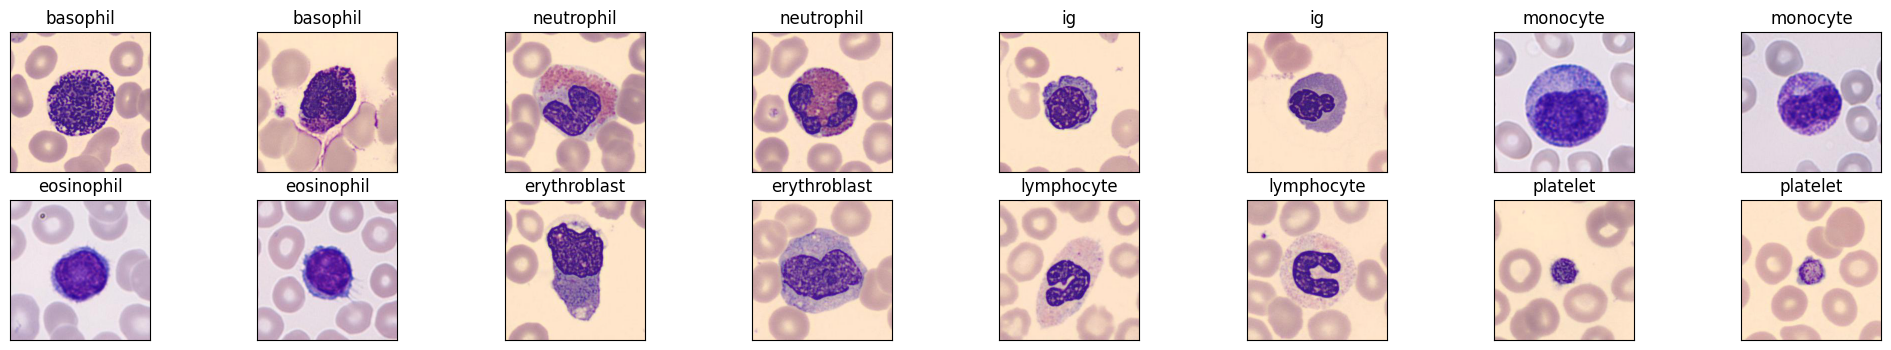

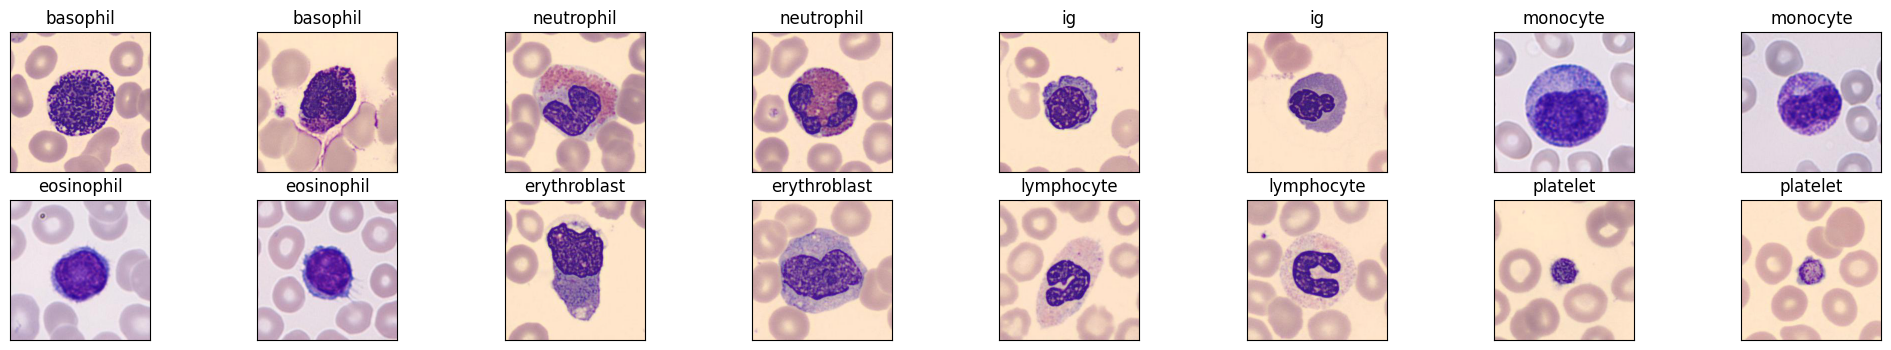

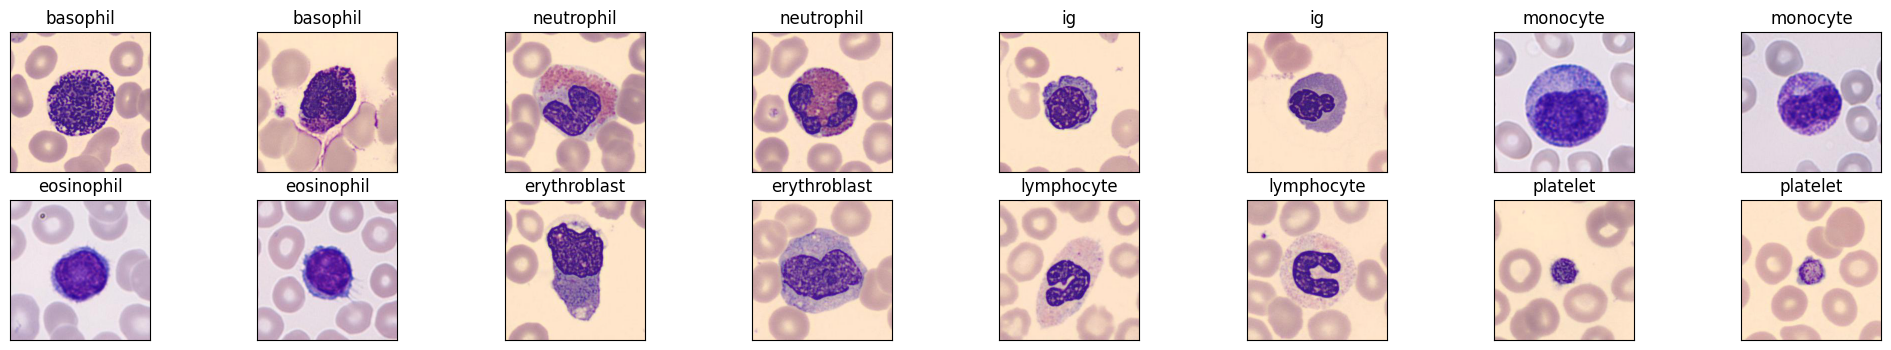

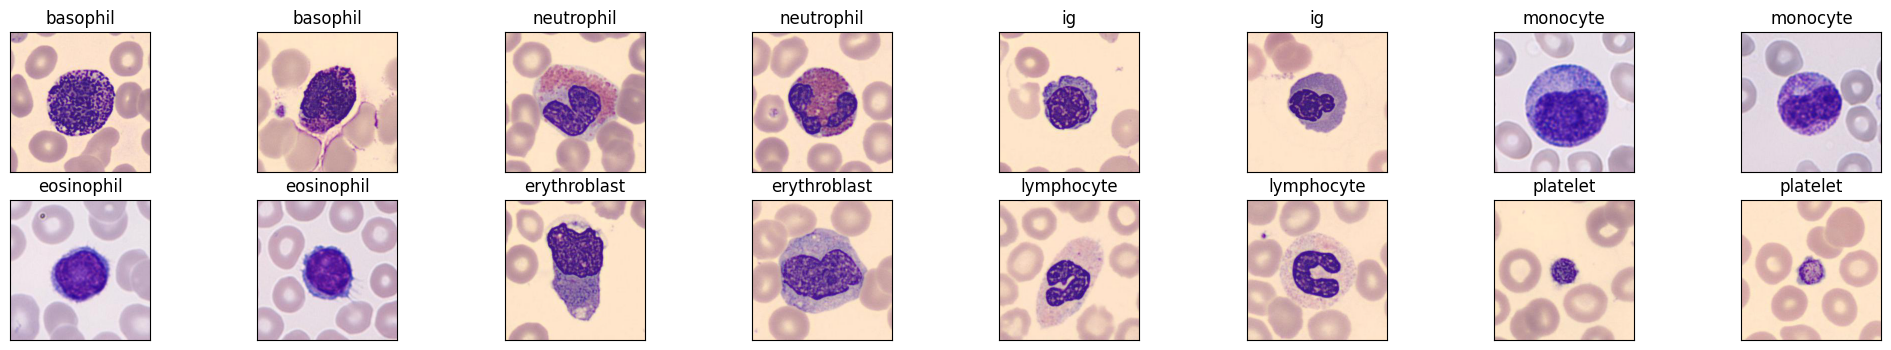

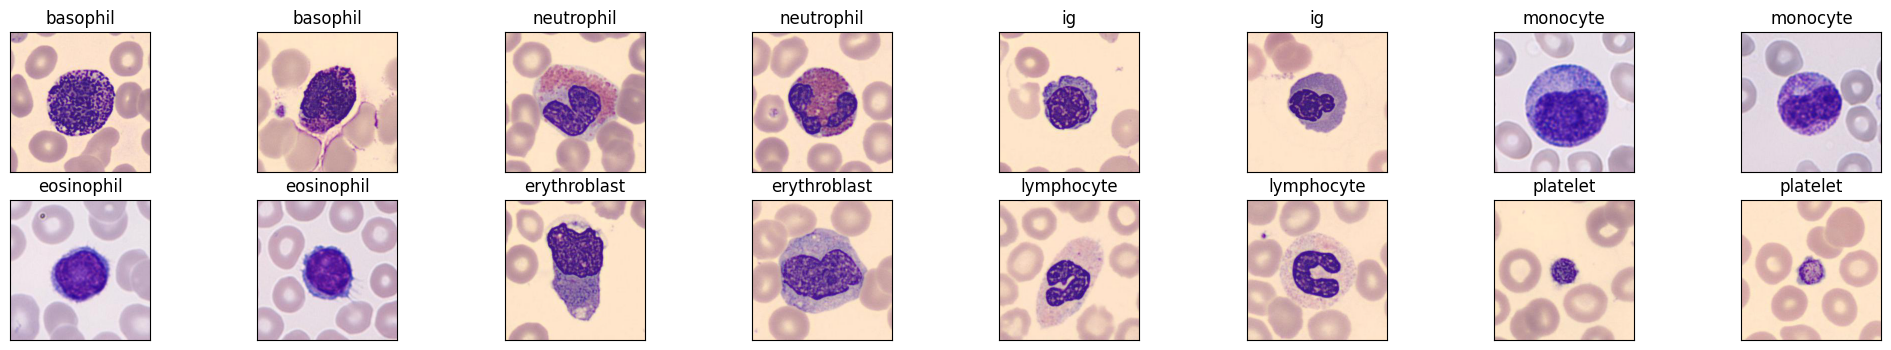

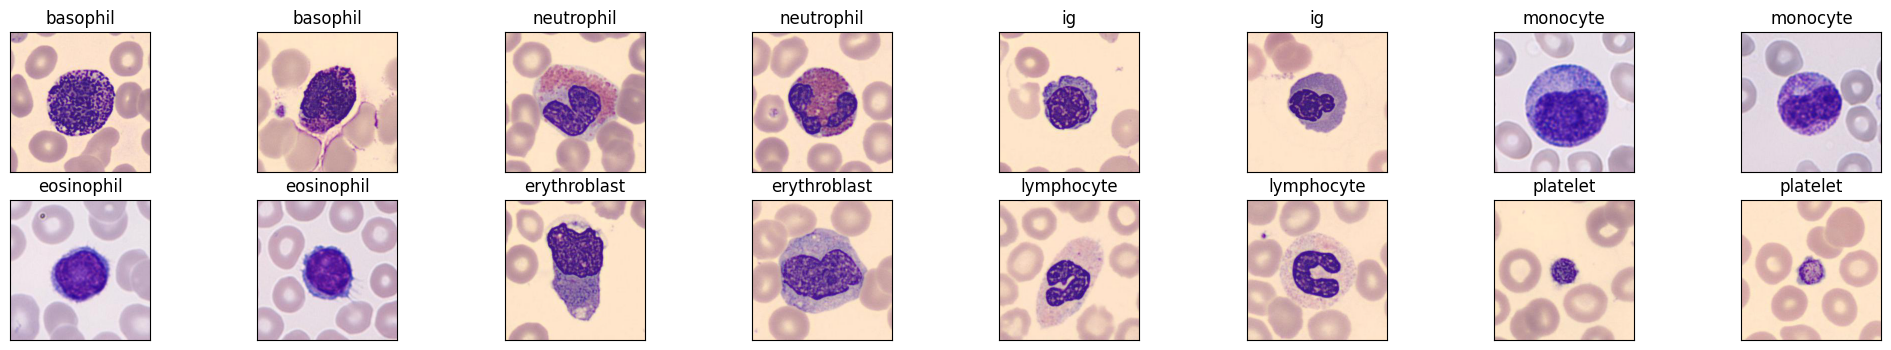

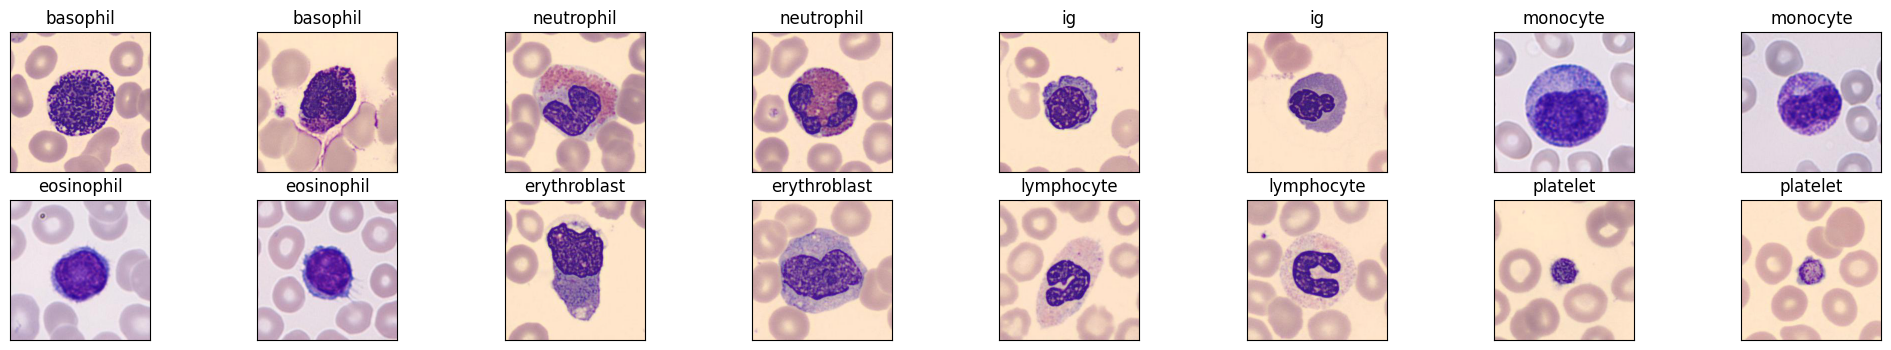

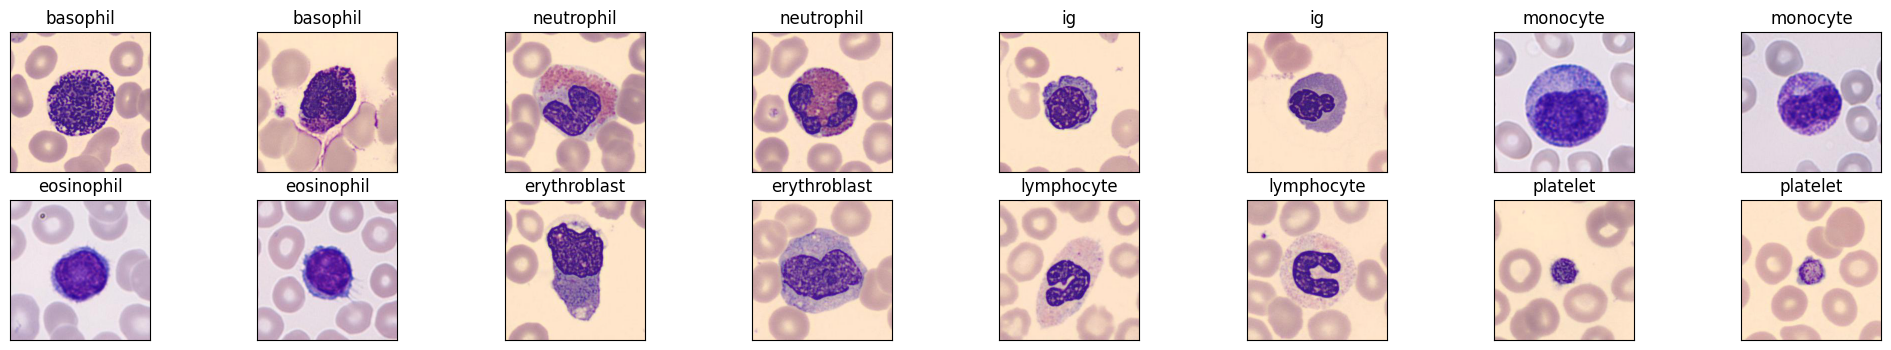

In [ ]:
overfit_model = proposed2(78400, 64,8)
print(overfit_model)
convalexnet=convalexnet.to(device)
train_overfit(overfit_model, overfit_data, batch_size=16, learning_rate=0.01, num_epochs=20)

In [ ]:
class test(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(test, self).__init__()
        #self.fc = nn.Linear(10*256*7*7 + hidden_size*3, num_class) #temp sizes, idk what the dimensions should be
        #256*7*7 for alexnet, 512*8*8 for vgg16
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60)
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)
    def forward(self, x):
        cnnpath = convalexnet(x) #convgg16(x)
        cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        if use_cuda:
          h0.cuda()
        #print("test",x.size(dim=0), x.dim)
        #print(h0.size, h0.dim)
        rnnpath, __=self.rnn(x, h0)
        rnnpath = rnnpath[:,-1,:]
        rnnpath = torch.flatten(rnnpath)
        cnnpath = torch.flatten(cnnpath, 1)
        print(cnnpath.size(0))
        print(rnnpath.size(0))
        #rnnpath = rnnpath.reshape((10, 32768))
        merged = torch.cat((cnnpath,rnnpath))
        #merged = torch.flatten(merged)

        x=self.fc(merged)
        return x

In [ ]:
class test2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(test2, self).__init__()
        #self.fc = nn.Linear(10*256*7*7 + hidden_size*3, num_class) #temp sizes, idk what the dimensions should be
        #256*7*7 for alexnet, 512*8*8 for vgg16
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60)
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)
    def forward(self, x):
        #y = torch.flatten(x, 1)
        #print(x.size())
        cnnpath = convalexnet(x) #convgg16(x)
        #cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        if use_cuda:
          h0.cuda()
        #print("test",x.size(dim=0), x.dim)
        #print(h0.size, h0.dim)
        rnnpath, __=self.rnn(x, h0)
        #print(rnnpath.shape) #swap dimensions

        rnnpath = rnnpath[-1,:,:]
        #print(cnnpath.shape, rnnpath.shape)

        cnnpath = torch.flatten(cnnpath, 1)
        cnnpath = F.relu(self.fcCNN(cnnpath))
        rnnpath = F.relu(self.fcRNN(rnnpath))
        #print(cnnpath.shape, rnnpath.shape)0.125
        

        merged = torch.cat((cnnpath, rnnpath),1)
        #print(merged.shape)
        x = self.fc(merged)

        return x

In [ ]:
test_model = test(78400, 64, 8)

In [ ]:
test_model2 = test2(78400, 64, 8)

In [ ]:
get_accuracy(test_model,test_loader)

here torch.Size([10, 3, 280, 280])
125440
192
tensor([1])


RuntimeError: ignored

In [ ]:
get_accuracy(test_model2,test_loader)

0.125

In [ ]:
get_accuracy(cnntest, test_loader)

0.02

In [ ]:
import matplotlib.pyplot as plt

def train(model, data, batch_size, learning_rate, num_epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
        print((f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}"))
    

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))